In [2]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


# Overview
- Intro about machine learning and education 
    - Examples, fears, hopes
- Simple Linear Regression
    - 2d Boston
        - Look at scatter plot of RM and MEDV
        - How do we fit a line?
        - How do we know the best fit?
        - How do we optimize?
    - 3d Boston
        - Same stuff
    - More d Boston
        - Same stuff
        - Requires understanding statistics
- Logistic Regression
    - MNIST: Lots of data
    - How does logistic regression work?
    - How do we feed in an image?
- Simple NN with MNIST
- CNN with MNIST
- Conclusion
    

In [4]:
boston_dataset = load_boston()

In [19]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
boston_df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_df['MEDV'] = boston_dataset.target

In [5]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


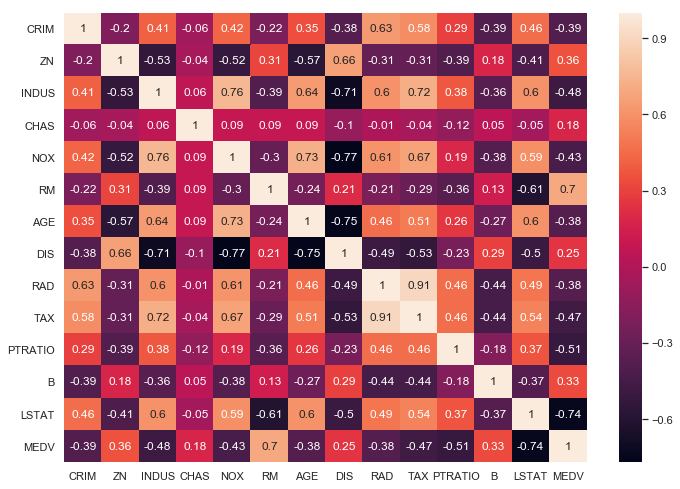

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_matrix = boston_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

In [6]:
# X = pd.DataFrame(np.c_[boston_df['LSTAT'], boston_df['RM'], boston_df['CRIM'], boston_df['ZN'], boston_df['INDUS'], boston_df['CHAS'], boston_df['NOX'], boston_df['AGE'], boston_df['DIS'], boston_df['RAD'], boston_df['TAX'], boston_df['PTRATIO'], boston_df['B']], columns = ['LSTAT','RM', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B'])
# X = pd.DataFrame(np.c_[boston_df['LSTAT'], boston_df['RM']], columns=['LSTAT', 'RM'])
X = pd.DataFrame(boston_df['RM'], columns=['RM'])
Y = boston_df['MEDV']

In [7]:
only_rooms_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['MEDV']], columns=['RM', 'MEDV'])

# What is Machine Learning?

# What is Machine Learning?
## Consider the familiar example -- RM is average number of rooms, MEDV is median value in $1000s
## We will try to predict the value of a home from the number of rooms.

In [8]:
only_rooms_df.head(10)

,RM,MEDV
0,6.575,24.0
1,6.421,21.6
2,7.185,34.7
3,6.998,33.4
4,7.147,36.2
5,6.430,28.7
6,6.012,22.9
7,6.172,27.1
8,5.631,16.5
9,6.004,18.9


# Does there seem to be any correlation between number of rooms and price?

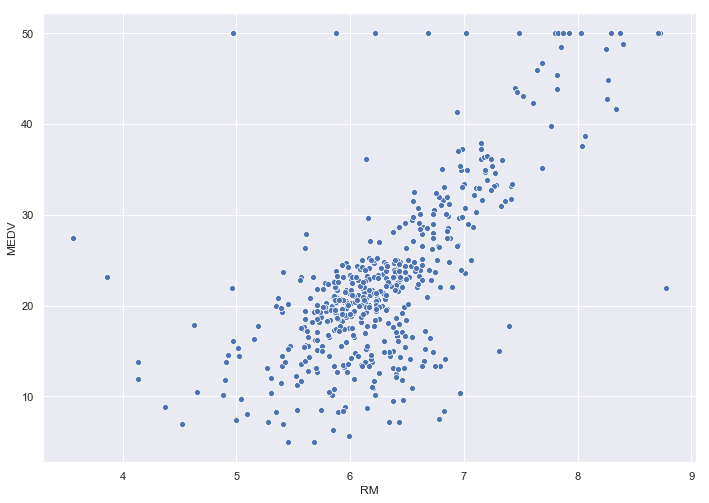

In [13]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

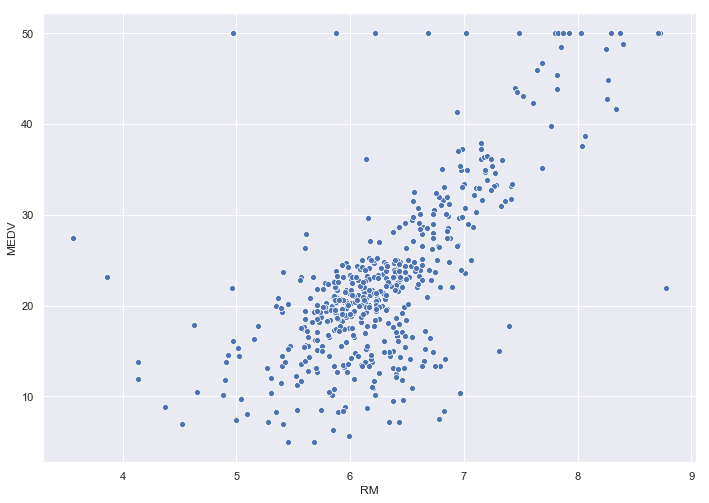

In [10]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

## Let's see if we can *fit a line* to this data.

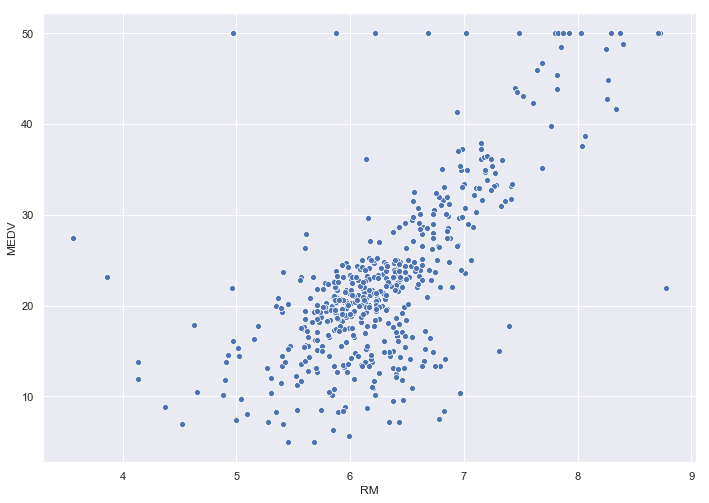

In [11]:
ax = sns.scatterplot(x="RM", y="MEDV", data=only_rooms_df)

## So we want to find $a$ and $b$ such that $y = ax + b$ where $y$ is the price of the house and $b$ is the number of rooms.

# Big Idea
## We have a bunch of data points that sort of make a line.
## We want to find values for $a$ and $b$ in $y = ax + b$ that *fit* the data points.
## We define a criterion for how well a line fits the data.
## We look for a line that optimizes our criterion.

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=666)

In [34]:
train['RM'].head()

343    6.696
342    6.540
458    6.301
376    6.649
302    6.495
Name: RM, dtype: float64

In [36]:
lin_model = LinearRegression()
lin_model.fit(train['RM'].to_frame(), train['MEDV'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [37]:
lin_model.coef_

array([[9.27368249]])

In [38]:
lin_model.intercept_

array([-35.64009735])

In [22]:
train, test = train_test_split(only_rooms_df, test_size = 0.25, random_state=666)

In [42]:
test['prediction'] = test['RM'] * lin_model.coef_[0] + lin_model.intercept_

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
test['diff_squared'] = (test['prediction'] - test['MEDV']) ** 2

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
test.head()

,RM,MEDV,prediction,diff_squared
81,6.619,23.9,25.742407,3.394464
453,7.393,17.8,32.920237,228.621576
311,6.122,22.1,21.133387,0.934341
291,7.148,37.3,30.648185,44.246642
360,6.398,25.0,23.692923,1.708450


In [48]:
test.diff_squared.sum() / len(test)

42.76818033219253

In [71]:
rooms_lstat_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['LSTAT'], boston_df['MEDV']], columns=['RM', 'LSTAT', 'MEDV'])
train, test = train_test_split(rooms_lstat_df, test_size = 0.25, random_state=666)
lin_model = LinearRegression()
lin_model.fit(np.c_[train['RM'], train['LSTAT']], train['MEDV'].to_frame())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
# test = test.drop(columns='MEDV')
# test['prediction'] =  lin_model.predict(test)
# with_preds = test
# with_preds['MEDV'] = test['MEDV']
with_preds['diff_squared'] = (with_preds['MEDV'] - with_preds['prediction']) ** 2
with_preds.head()

,RM,LSTAT,prediction,MEDV,diff_squared
81,6.619,7.22,27.861800,23.9,15.695861
453,7.393,16.74,26.251842,17.8,71.433626
311,6.122,5.98,25.901409,22.1,14.450713
291,7.148,3.56,33.008254,37.3,18.419088
360,6.398,7.79,26.301045,25.0,1.692718


In [74]:
with_preds.diff_squared.sum() / len(with_preds)

28.06626963161934

In [75]:
mean_squared_error(with_preds.MEDV, with_preds.prediction)

28.06626963161934

In [81]:
rooms_lstat_pt_df = pd.DataFrame(np.c_[boston_df['RM'], boston_df['LSTAT'], boston_df['PTRATIO']], columns=['RM', 'LSTAT', 'PTRATIO'])
Y = boston_df['MEDV']
X_train, X_test, Y_train, Y_test = train_test_split(rooms_lstat_pt_df, Y, test_size = 0.25, random_state=666)
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)
predictions = lin_model.predict(X_test)
mse = mean_squared_error(predictions, Y_test)
r2 = r2_score(predictions, Y_test)
print("mse: {} -- r^2: {}".format(mse, r2))

mse: 26.62571646686159 -- r^2: 0.4956835622307818


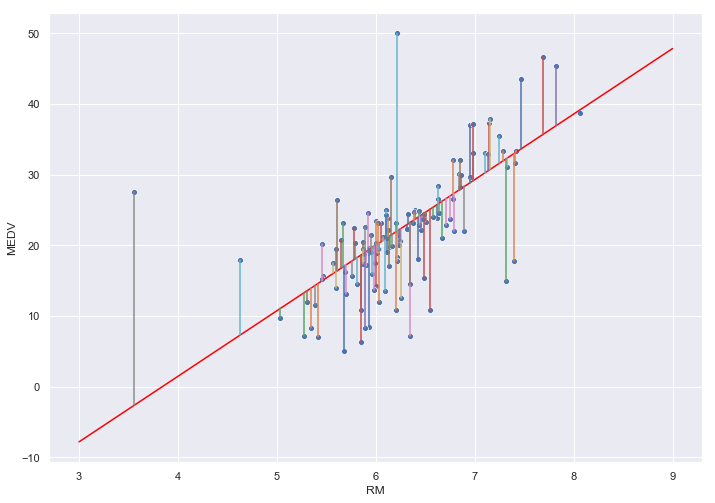

In [39]:
dataset = test
ax = sns.scatterplot(x="RM", y="MEDV", data=dataset)
x = np.linspace(3, 9, 1000)
ax.plot(x, 9.274 * x - 35.64, color='red')

for row in dataset.itertuples():
    ax.plot([row.RM, row.RM], [row.MEDV, 9.274 * row.RM - 35.64])

In [32]:
X_test['MEDV'] = Y_test
test = X_test

/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/mmoran/anaconda/envs/mmc2019/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


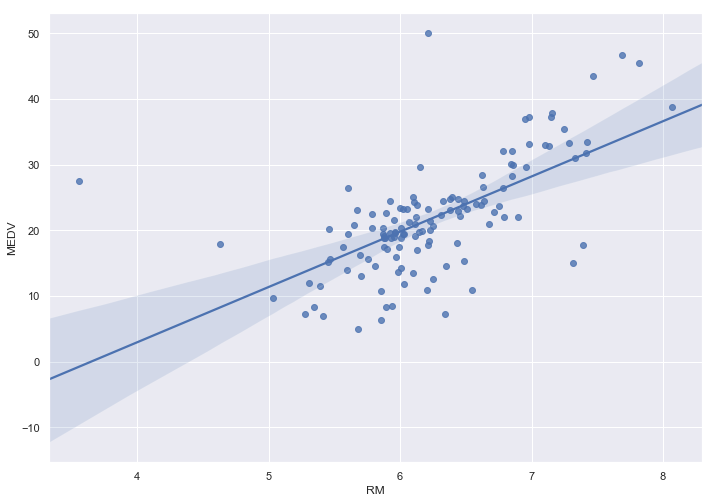

In [34]:
sns.regplot(x="RM", y="MEDV", data=test)

In [75]:

# model evaluation for training set
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 5.516352882433443
R2 score is 0.6500177830034586


The model performance for testing set
--------------------------------------
RMSE is 5.571150318932446
R2 score is 0.5820013780757898


In [68]:
preds = lin_model.predict(X_test)

In [5]:
numpy_vals = boston_df.values

In [19]:
X = numpy_vals[:,0:13]
Y = numpy_vals[:,13]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=666)

In [20]:
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [24]:
model.fit(X_train, Y_train, batch_size=5, epochs=100, validation_split=0.20)

Train on 323 samples, validate on 81 samples
Epoch 1/100
323/323 [==============================] - 0s 766us/step - loss: 13.1700 - val_loss: 14.5666
Epoch 2/100
323/323 [==============================] - 0s 639us/step - loss: 12.9502 - val_loss: 14.7375
Epoch 3/100
323/323 [==============================] - 0s 597us/step - loss: 12.5215 - val_loss: 14.1391
Epoch 4/100
323/323 [==============================] - 0s 638us/step - loss: 12.3891 - val_loss: 14.1524
Epoch 5/100
323/323 [==============================] - 0s 698us/step - loss: 12.4819 - val_loss: 14.4678
Epoch 6/100
323/323 [==============================] - 0s 798us/step - loss: 12.4983 - val_loss: 16.3261
Epoch 7/100
323/323 [==============================] - 0s 616us/step - loss: 13.1802 - val_loss: 14.3676
Epoch 8/100
323/323 [==============================] - 0s 613us/step - loss: 12.2310 - val_loss: 13.4159
Epoch 9/100
323/323 [==============================] - 0s 622us/step - loss: 12.7508 - val_loss: 14.6194
Epoch 10/1

Epoch 78/100
323/323 [==============================] - 0s 631us/step - loss: 12.7725 - val_loss: 14.5009
Epoch 79/100
323/323 [==============================] - 0s 596us/step - loss: 12.6153 - val_loss: 15.4116
Epoch 80/100
323/323 [==============================] - 0s 604us/step - loss: 13.0986 - val_loss: 13.8880
Epoch 81/100
323/323 [==============================] - 0s 589us/step - loss: 13.7617 - val_loss: 15.8201
Epoch 82/100
323/323 [==============================] - 0s 628us/step - loss: 12.9504 - val_loss: 15.1033
Epoch 83/100
323/323 [==============================] - 0s 596us/step - loss: 13.0860 - val_loss: 18.9663
Epoch 84/100
323/323 [==============================] - 0s 612us/step - loss: 13.2484 - val_loss: 15.5310
Epoch 85/100
323/323 [==============================] - 0s 631us/step - loss: 12.8176 - val_loss: 15.5995
Epoch 86/100
323/323 [==============================] - 0s 610us/step - loss: 12.9041 - val_loss: 17.3973
Epoch 87/100
323/323 [========================

In [7]:
def simple_model():
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [15]:
seed = 666
np.random.seed(seed)
estimator = KerasRegressor(build_fn=simple_model, epochs=100, batch_size=5, verbose=0)

In [14]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -33.05 (23.22) MSE


In [17]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=simple_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -28.40 (27.97) MSE


In [5]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [7]:
Y_train[0]

5

In [2]:
admission_dataframe = pd.read_excel('/Users/mmoran/Downloads/IPEDS_data.xlsx')

In [3]:
admission_dataframe.head()

,ID number,Name,year,ZIP code,Highest degree offered,County name,Longitude location of institution,Latitude location of institution,Religious affiliation,Offers Less than one year certificate,...,Percent of freshmen receiving federal grant aid,Percent of freshmen receiving Pell grants,Percent of freshmen receiving other federal grant aid,Percent of freshmen receiving state/local grant aid,Percent of freshmen receiving institutional grant aid,Percent of freshmen receiving student loan aid,Percent of freshmen receiving federal student loans,Percent of freshmen receiving other loan aid,Endowment assets (year end) per FTE enrollment (GASB),Endowment assets (year end) per FTE enrollment (FASB)
0,100654,Alabama A & M University,2013,35762,Doctor's degree - research/scholarship,Madison County,-86.568502,34.783368,Not applicable,Implied no,...,81.0,81.0,7.0,1.0,32.0,89.0,89.0,1.0,NaN,NaN
1,100663,University of Alabama at Birmingham,2013,35294-0110,Doctor's degree - research/scholarship and pro...,Jefferson County,-86.809170,33.502230,Not applicable,Implied no,...,36.0,36.0,10.0,0.0,60.0,56.0,55.0,5.0,24136.0,NaN
2,100690,Amridge University,2013,36117-3553,Doctor's degree - research/scholarship and pro...,Montgomery County,-86.174010,32.362609,Churches of Christ,Implied no,...,90.0,90.0,0.0,40.0,90.0,100.0,100.0,0.0,NaN,302.0
3,100706,University of Alabama in Huntsville,2013,35899,Doctor's degree - research/scholarship and pro...,Madison County,-86.638420,34.722818,Not applicable,Yes,...,31.0,31.0,4.0,1.0,63.0,46.0,46.0,3.0,11502.0,NaN
4,100724,Alabama State University,2013,36104-0271,Doctor's degree - research/scholarship and pro...,Montgomery County,-86.295677,32.364317,Not applicable,Implied no,...,76.0,76.0,13.0,11.0,34.0,81.0,81.0,0.0,13202.0,NaN


In [4]:
admission_dataframe.columns.values

array(['ID number', 'Name', 'year', 'ZIP code', 'Highest degree offered',
       'County name', 'Longitude location of institution',
       'Latitude location of institution', 'Religious affiliation',
       'Offers Less than one year certificate',
       'Offers One but less than two years certificate',
       "Offers Associate's degree",
       'Offers Two but less than 4 years certificate',
       "Offers Bachelor's degree", 'Offers Postbaccalaureate certificate',
       "Offers Master's degree", "Offers Post-master's certificate",
       "Offers Doctor's degree - research/scholarship",
       "Offers Doctor's degree - professional practice",
       "Offers Doctor's degree - other", 'Offers Other degree',
       'Applicants total', 'Admissions total', 'Enrolled total',
       'Percent of freshmen submitting SAT scores',
       'Percent of freshmen submitting ACT scores',
       'SAT Critical Reading 25th percentile score',
       'SAT Critical Reading 75th percentile score',
       